In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer-cleaned-file/Clean_File.csv
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z


In [23]:
import matplotlib.pyplot as plt
import re
import time
import warnings
import seaborn as sns
import math
import nltk
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE

In [24]:
df1 = pd.read_csv('/kaggle/input/cancer-cleaned-file/Clean_File.csv')

In [25]:
df1.head()

,Unnamed: 0,ID,Gene,Variation,Class,TEXT
0,0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,1,CBL,W802*,2,abstract background non small cell lung cance...
2,2,2,CBL,Q249E,2,abstract background non small cell lung cance...
3,3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [26]:
df2 = df1.drop(columns=['Unnamed: 0'])

In [27]:
# Getting labels as 'Class' column
y_true = df2['Class'].values

# splitting into train,test,split
X_train, test_df, y_train, y_test = train_test_split(df2, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [28]:
train_df.head()

,ID,Gene,Variation,Class,TEXT
2408,2408,NF1,Deletion,4,germline heterozygous alterations tumor suppre...
2172,2172,PTEN,K125R,3,pten phosphatase tensin homolog phosphatase un...
1407,1407,FGFR3,K508M,6,FGFR3 K508M
3023,3023,KIT,D820E,2,metastatic thymic carcinoma aggressive neoplas...
2079,2079,TET2,M1293A,6,tet proteins oxidize 5 methylcytosine 5mc dna ...


In [29]:
cv_df.head()

,ID,Gene,Variation,Class,TEXT
469,469,TP53,Q144R,1,tumor suppressor p53 dependent apoptosis thoug...
2424,2424,BRCA1,G1743R,1,abstract brca1 gene individuals risk breast o...
811,811,ERCC2,D513Y,1,increasing application gene panels familial ca...
3090,3090,NOTCH1,F1592S,7,majority human pancreatic cancers activating m...
2018,2018,MAP2K1,E120Q,5,histiocytic neoplasms clonal hematopoietic dis...


# GENERATING RANDOM MODEL FOR WORST LOGLOSS

In [30]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

#create output array as same size of CV data
cv_predicted = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("LogLoss on CV data: ",log_loss(y_cv,cv_predicted,eps=1e-15))

#create output array as same size of Test data
test_predicted = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("LogLoss on Test data: ",log_loss(y_test,test_predicted,eps=1e-15))

LogLoss on CV data:  2.512144687876985
LogLoss on Test data:  2.488054263402728


In [11]:
predicted_y = np.argmax(test_predicted,axis=1)
predicted_y = predicted_y + 1

### Confusion matrix

In [12]:
c = confusion_matrix(y_test,predicted_y)

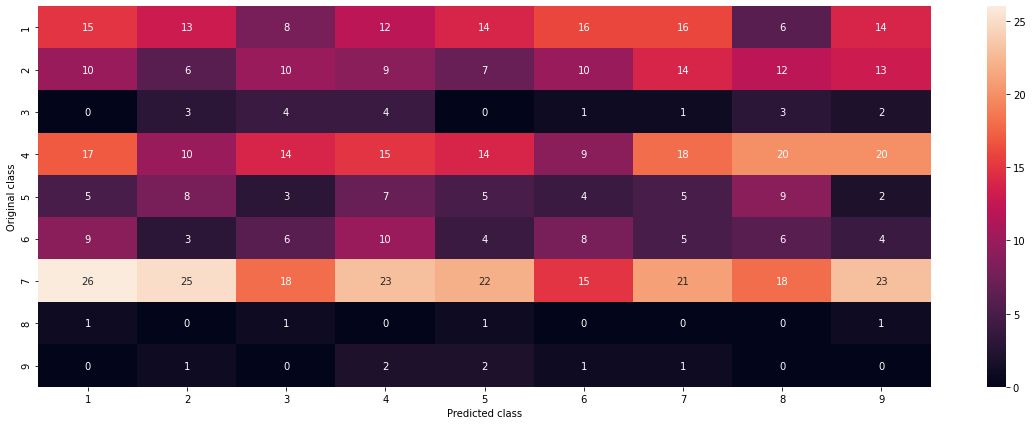

In [13]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(c,annot=True,xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted class')
plt.ylabel('Original class')
plt.show()

Tells us how many predicted class actually belong to that class.

### Precision matrix

In [14]:
b = (c/c.sum(axis=0))

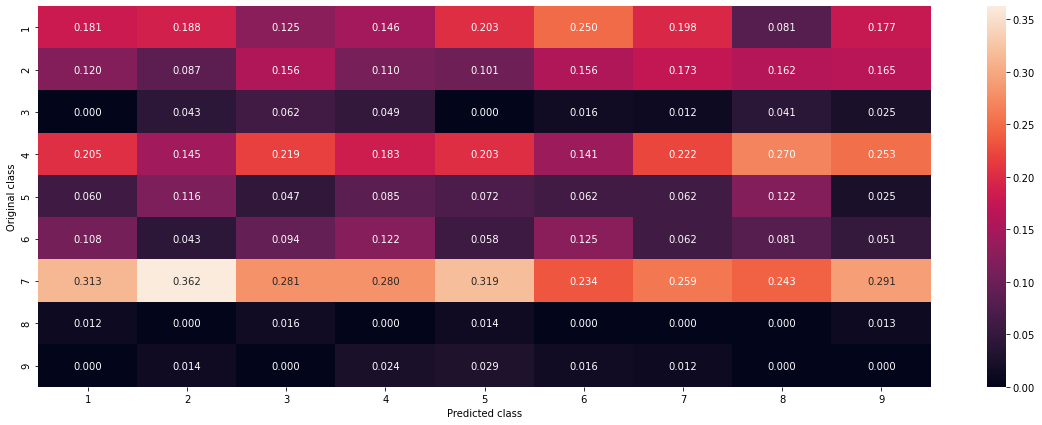

In [15]:
plt.figure(figsize=(20,7))
sns.heatmap(b,annot=True,xticklabels=labels,fmt='.3f',yticklabels=labels)
plt.xlabel('Predicted class')
plt.ylabel('Original class')
plt.show()

Tells us how much percentage the class predicted actually belongs to that class.

Ex: (1,1) -> 0.152 i.e 15.2% of predicted class '1' actually is class '1'

### Recall matrix

In [16]:
a = (((c.T)/(c.sum(axis=1))).T)

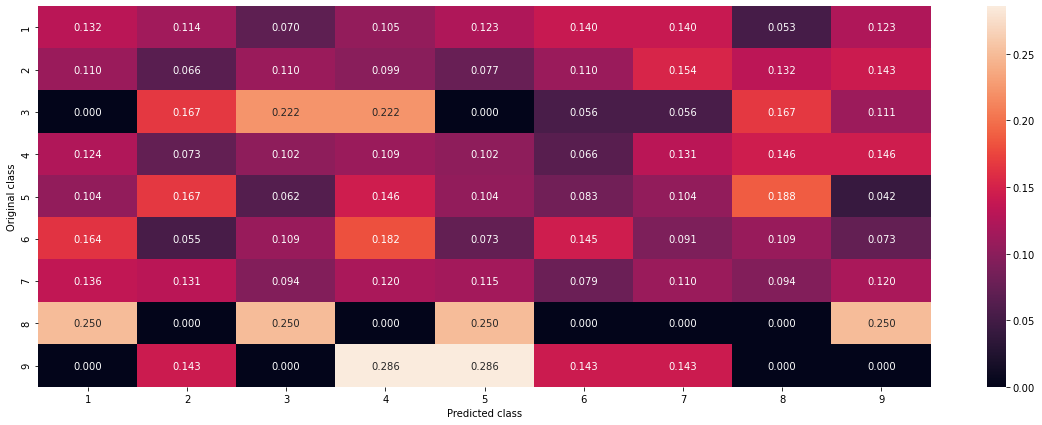

In [17]:
plt.figure(figsize=(20,7))
sns.heatmap(a,annot=True,xticklabels=labels,fmt='.3f',yticklabels=labels)
plt.xlabel('Predicted class')
plt.ylabel('Original class')
plt.show()

Tells how much percentage of total actual class were predicted to be that class.

## Feature engineering

# 1.Gene column

In [18]:
# Exploring 'Gene' column in train
unique_genes = train_df['Gene'].value_counts()
print('No.of unique genes: ',unique_genes.shape[0])
print(unique_genes.head(15))

No.of unique genes:  240
BRCA1     176
TP53      105
EGFR       89
BRCA2      82
PTEN       81
BRAF       61
KIT        59
ALK        48
ERBB2      40
PDGFRA     38
PIK3CA     36
FGFR2      33
KRAS       31
TSC2       31
FLT3       31
Name: Gene, dtype: int64


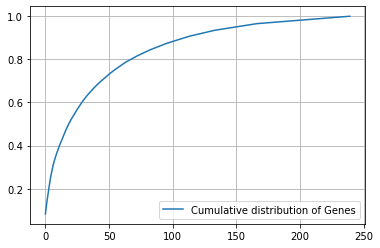

In [19]:
# Cumulative distribution plot
s = sum(unique_genes.values)
h = unique_genes.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

We can infer that top 50 genes are contributing towards top 75% of the data.

In [20]:
# Exploring 'Gene' column in cv
unique_genes = cv_df['Gene'].value_counts()
print('No.of unique genes: ',unique_genes.shape[0])
print(unique_genes.head(15))

No.of unique genes:  132
BRCA1     38
TP53      21
EGFR      20
BRAF      18
KIT       18
PTEN      17
BRCA2     16
FLT3      14
ERBB2     14
TSC2      10
FGFR3     10
MAP2K1    10
PDGFRA     9
MSH2       9
MTOR       9
Name: Gene, dtype: int64


### Categorical features

##### One hot encoding

In [78]:
# one-hot encoding of Gene features.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotcoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotcoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotcoding = gene_vectorizer.transform(cv_df['Gene'])

In [32]:
# shape for just one column
print(train_gene_feature_onehotcoding.shape)
print(cv_gene_feature_onehotcoding.shape)

(2124, 231)
(532, 231)


In [23]:
# column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'i

#### Response encoding

In [24]:
#response encdoing with Laplace smooting.
# alpha : used for laplace smoothing
# feature : ['gene','variation']
# df : ['train_df','test_df','cv_df']

#algorith
# ----------
# Consider all unique values and no.of occurances of given feature in train data
# Build a vector (1*9), the first element = (number of times it occured in class1 + 10*alpha / no.of times)
# create a dic (gv_dict) i.e like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there in train:
# we add [1/9]*9 to 'gv_fea'
# return 'gv_fea'
# ------------

# 'gv_fea': Gene variation Feature Dict

In [25]:
z = train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')]
z.head(10)

,ID,Gene,Variation,Class,TEXT
2463,2463,BRCA1,V1833M,1,abstract germline mutations inactivate tumor s...
2614,2614,BRCA1,M1R,1,large number missense mutations identified wit...
2441,2441,BRCA1,F1761I,1,abstract brca1 gene individuals risk breast o...
2639,2639,BRCA1,V1653M,1,abstract germline mutations inactivate tumor s...
2567,2567,BRCA1,T1685A,1,abstract brca1 gene individuals risk breast o...
2599,2599,BRCA1,M1689R,1,abstract brca1 gene individuals risk breast o...
2582,2582,BRCA1,D1739Y,1,abstract brca1 gene individuals risk breast o...
2524,2524,BRCA1,E1836K,1,genetic screening breast ovarian cancer suscep...
2486,2486,BRCA1,S1841R,1,genetic screening breast ovarian cancer suscep...
2600,2600,BRCA1,D1739E,1,abstract germline mutations inactivate tumor s...


DataFrame is grouped by same 'Gene' & 'Class'

In [26]:
# Get gene variation feature dict
def get_gv_fea_dict(alpha,feature,df):
    
    # get frequency of feature
    value_count = train_df[feature].value_counts()
    
    # Feature variation Dict: Probablity array for each gene/variation
    gv_dict = dict()
    
    # freq contains frequency whereas i is corresponding feature value 
    for i,freq in value_count.items():
        # vec will contain prob of gene/variation belonging to particular class
        # vec has length 9 i.e no.of classes 
        vec = []
        for k in range(1,10):
            
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            vec.append((cls_cnt.shape[0] + alpha*10)/(freq + 90*alpha))
        gv_dict[i] = vec
    
    return gv_dict

#Get gene variation feature
def get_gv_fea(alpha,feature,df):
    
    # get gene variation feature dictionary
    gv_dict = get_gv_fea_dict(alpha,feature,df)
    
    # get frequency of feature
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    
    for index,row in df.iterrows():
        
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    
    return gv_fea
    

In [27]:
gv_dic = get_gv_fea_dict(1,'Gene',train_df)
gv_dic['BRCA1']

[0.17293233082706766,
 0.03759398496240601,
 0.08646616541353383,
 0.16917293233082706,
 0.2518796992481203,
 0.16917293233082706,
 0.03759398496240601,
 0.03759398496240601,
 0.03759398496240601]

In [28]:
# response-encoding of the Gene feature
alpha = 1
train_gene_feature_responsecoding = np.array(get_gv_fea(alpha,'Gene',train_df))
test_gene_feature_responsecoding = np.array(get_gv_fea(alpha,'Gene',test_df))
cv_gene_feature_responsecoding  = np.array(get_gv_fea(alpha,'Gene',cv_df))

In [29]:
train_gene_feature_responsecoding.shape

(2124, 9)

### Significance of gene feature

In [30]:
# hyperparam for SGD classifier
alpha = [10 ** x for x in range(-5,1)]

In [31]:
cv_log_error = []
for i in alpha:
    # SGD classifier with logistic regression and l2 penaly
    clf = SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_gene_feature_onehotcoding,y_train)
    # calibrated for output to be in probality format using sigmoid
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotcoding,y_train)
    #predict on cv data
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotcoding)
    #append logloss and print
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print("For values of alpha = ",i,"The logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

For values of alpha =  1e-05 The logloss is: 1.2103509647674038
For values of alpha =  0.0001 The logloss is: 1.1915144404128346
For values of alpha =  0.001 The logloss is: 1.2415406232684387
For values of alpha =  0.01 The logloss is: 1.355350113103517
For values of alpha =  0.1 The logloss is: 1.472108955940955
For values of alpha =  1 The logloss is: 1.5137467107760962


#### Logloss is better than random model hence 'Gene' is good feature.

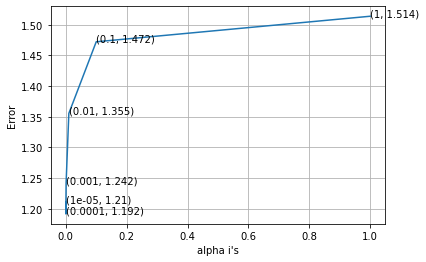

In [32]:
# plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],np.round(txt,decimals=3)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()
                

best alpha : 0.0001

In [33]:
# Using best alpha value, compute log loss
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_gene_feature_onehotcoding,y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_onehotcoding,y_train)
predict_y = sig_clf.predict_proba(train_gene_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.0001 The train logloss is: 0.9926418688860343
For value of best alpha =  0.0001 The cv logloss is: 1.1915144404128346
For value of best alpha =  0.0001 The test logloss is: 1.152133365136377


#### No significant overfitting 

Let's check coverage/overlap of the datasets

In [34]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [35]:
print('1. In test data',test_coverage,'out of',test_df.shape[0],':',test_coverage/test_df.shape[0])
print('1. In cv data',cv_coverage,'out of',cv_df.shape[0],':',cv_coverage/cv_df.shape[0])

1. In test data 648 out of 665 : 0.9744360902255639
1. In cv data 524 out of 532 : 0.9849624060150376


Good coverage

# 2.Variation column

In [36]:
# Exploring 'Gene' column
unique_var = train_df['Variation'].value_counts()
print('No.of unique variations: ',unique_var.shape[0])
print(unique_var.head(15))

No.of unique variations:  1932
Truncating_Mutations    57
Deletion                50
Amplification           47
Fusions                 18
Q61L                     3
T58I                     3
Overexpression           3
Q61R                     3
G12V                     2
E17K                     2
G67R                     2
E330K                    2
T73I                     2
P34R                     2
P130S                    2
Name: Variation, dtype: int64


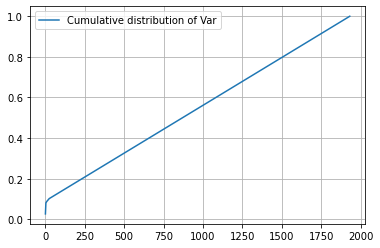

In [37]:
# Cumulative distribution plot
s = sum(unique_var.values)
h = unique_var.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Var')
plt.grid()
plt.legend()
plt.show()

Keeps on increasing, one-hot-encoding doesn't looks good

In [79]:
# one-hot encoding of Gene features.
var_vectorizer = CountVectorizer()
train_var_feature_onehotcoding = var_vectorizer.fit_transform(train_df['Variation'])
test_var_feature_onehotcoding = var_vectorizer.transform(test_df['Variation'])
cv_var_feature_onehotcoding = var_vectorizer.transform(cv_df['Variation'])

In [34]:
# shape for just one column
print(train_var_feature_onehotcoding.shape)
print(cv_var_feature_onehotcoding.shape)

(2124, 1949)
(532, 1949)


In [40]:
# response-encoding of the Var feature
alpha = 1
train_var_feature_responsecoding = np.array(get_gv_fea(alpha,'Variation',train_df))
test_var_feature_responsecoding = np.array(get_gv_fea(alpha,'Variation',test_df))
cv_var_feature_responsecoding  = np.array(get_gv_fea(alpha,'Variation',cv_df))

In [41]:
train_var_feature_responsecoding.shape

(2124, 9)

#### Significance of Variation feature

In [42]:
# hyperparam for SGD classifier
alpha = [10 ** x for x in range(-5,1)]

In [43]:
cv_log_error = []
for i in alpha:
    # SGD classifier with logistic regression and l2 penaly
    clf = SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_var_feature_onehotcoding,y_train)
    # calibrated for output to be in probality format using sigmoid
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_var_feature_onehotcoding,y_train)
    #predict on cv data
    predict_y = sig_clf.predict_proba(cv_var_feature_onehotcoding)
    #append logloss and print
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print("For values of alpha = ",i,"The logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

For values of alpha =  1e-05 The logloss is: 1.7189093954800225
For values of alpha =  0.0001 The logloss is: 1.711068223932721
For values of alpha =  0.001 The logloss is: 1.7138758845373958
For values of alpha =  0.01 The logloss is: 1.7220155812344053
For values of alpha =  0.1 The logloss is: 1.7257276027630986
For values of alpha =  1 The logloss is: 1.7272776432868235


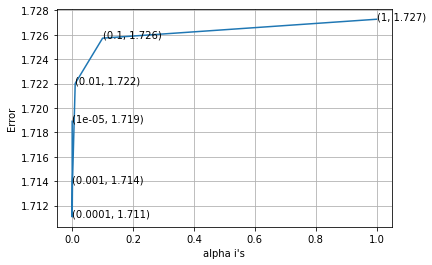

In [44]:
# plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],np.round(txt,decimals=3)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()
               

best alpha = 0.0001

In [45]:
# Using best alpha value, compute log loss
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_var_feature_onehotcoding,y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_var_feature_onehotcoding,y_train)
predict_y = sig_clf.predict_proba(train_var_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_var_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_var_feature_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.0001 The train logloss is: 0.6795890916351658
For value of best alpha =  0.0001 The cv logloss is: 1.711068223932721
For value of best alpha =  0.0001 The test logloss is: 1.6747190099259779


Clearly, overfitting but overall a good feature

In [46]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [47]:
print('1. In test data',test_coverage,'out of',test_df.shape[0],':',test_coverage/test_df.shape[0])
print('1. In cv data',cv_coverage,'out of',cv_df.shape[0],':',cv_coverage/cv_df.shape[0])

1. In test data 77 out of 665 : 0.11578947368421053
1. In cv data 52 out of 532 : 0.09774436090225563


Very poor coverage

# 3.Text column

In [48]:
# word freq in text column
def extract_dictionary(txt_df):
    dictionary = defaultdict(int)
    for index,row in txt_df.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [49]:
def get_text_responsecoding(df):
    txt_fea_responsecoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index,row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            txt_fea_responsecoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return txt_fea_responsecoding

In [52]:
train_text_fea_responsecoding = get_text_responsecoding(train_df)
test_text_fea_responsecoding = get_text_responsecoding(test_df)
cv_text_fea_responsecoding = get_text_responsecoding(cv_df)

In [53]:
# Convert each row values such that they sum to 1
train_text_fea_responsecoding = (train_text_fea_responsecoding.T/train_text_fea_responsecoding.sum(axis=1)).T
test_text_fea_responsecoding = (test_text_fea_responsecoding.T/test_text_fea_responsecoding.sum(axis=1)).T
cv_text_fea_responsecoding = (cv_text_fea_responsecoding.T/cv_text_fea_responsecoding.sum(axis=1)).T

In [80]:
# Count vectorizer with all the words that occured atleast 3 times
text_vectorizer = CountVectorizer(min_df=3)
train_text_fea_onehotcoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_fea = text_vectorizer.get_feature_names()

# This will sum every row and return (1 * no.of features) vectors
train_text_fea_counts = train_text_fea_onehotcoding.sum(axis=0).A1

#zip word with their frequency
text_fea_dict = dict(zip(list(train_text_fea),train_text_fea_counts))

print("No.of unique words are ",len(train_text_fea))


No.of unique words are  54356


In [55]:
# Ths list will contain 9 dictionaries where each corresponds to a class
dict_list = []
for i in range(1,10):
    # Build on i'th class text data 
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary(cls_text))

# Build on whole training text data
total_dict = extract_dictionary(train_df)


In [56]:
confuse_array = []
for i in train_text_fea:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10)/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [36]:
# Normalize every feature
train_text_fea_onehotcoding = normalize(train_text_fea_onehotcoding,axis=0)

test_text_fea_onehotcoding = text_vectorizer.transform(test_df['TEXT'])
test_text_fea_onehotcoding = normalize(test_text_fea_onehotcoding,axis=0)

cv_text_fea_onehotcoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_fea_onehotcoding = normalize(cv_text_fea_onehotcoding,axis=0)


In [58]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(),key=lambda x:x[1],reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))    

In [59]:
print(Counter(sorted_text_occur))

Counter({3: 6025, 4: 3356, 5: 2990, 6: 2782, 8: 2252, 7: 1950, 9: 1629, 10: 1472, 12: 1265, 11: 1122, 15: 1018, 13: 849, 16: 846, 14: 809, 18: 674, 17: 662, 19: 627, 20: 564, 21: 547, 24: 499, 26: 412, 22: 407, 38: 378, 27: 365, 23: 361, 29: 345, 25: 341, 30: 324, 32: 307, 28: 298, 36: 294, 33: 287, 51: 283, 31: 250, 40: 247, 34: 241, 42: 233, 37: 231, 35: 220, 48: 216, 39: 205, 41: 188, 45: 186, 43: 171, 56: 165, 44: 164, 46: 156, 50: 151, 54: 148, 52: 145, 49: 143, 47: 140, 53: 136, 60: 135, 57: 135, 65: 126, 59: 125, 55: 123, 58: 115, 68: 107, 63: 106, 73: 105, 69: 104, 84: 103, 66: 103, 72: 98, 62: 97, 61: 97, 78: 96, 76: 96, 70: 94, 67: 94, 64: 88, 75: 83, 71: 79, 77: 77, 80: 76, 74: 76, 87: 74, 90: 73, 104: 70, 85: 69, 82: 67, 83: 66, 93: 65, 96: 64, 81: 64, 79: 63, 98: 62, 99: 61, 95: 61, 92: 61, 103: 60, 109: 59, 94: 59, 100: 58, 88: 58, 102: 57, 86: 56, 105: 55, 91: 54, 89: 54, 126: 51, 108: 51, 114: 50, 120: 49, 119: 49, 110: 49, 97: 48, 153: 46, 135: 46, 111: 45, 107: 45, 12

In [60]:
# hyperparam for SGD classifier
alpha = [10 ** x for x in range(-5,1)]

In [61]:
cv_log_error = []
for i in alpha:
    # SGD classifier with logistic regression and l2 penaly
    clf = SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_text_fea_onehotcoding,y_train)
    # calibrated for output to be in probality format using sigmoid
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_text_fea_onehotcoding,y_train)
    #predict on cv data
    predict_y = sig_clf.predict_proba(cv_text_fea_onehotcoding)
    #append logloss and print
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print("For values of alpha = ",i,"The logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

For values of alpha =  1e-05 The logloss is: 1.3391179648808889
For values of alpha =  0.0001 The logloss is: 1.211172513042835
For values of alpha =  0.001 The logloss is: 1.200448857944814
For values of alpha =  0.01 The logloss is: 1.2847731584233093
For values of alpha =  0.1 The logloss is: 1.4686696316724155
For values of alpha =  1 The logloss is: 1.656053865480601


best alpha = 0.0001

In [62]:

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_text_fea_onehotcoding,y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_text_fea_onehotcoding,y_train)
predict_y = sig_clf.predict_proba(train_text_fea_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_fea_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_fea_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.001 The train logloss is: 0.6484174881700763
For value of best alpha =  0.001 The cv logloss is: 1.200448857944814
For value of best alpha =  0.001 The test logloss is: 1.1272103199874453


A little bit overfitting.

In [63]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_fea) & set(df_text_features))
    return len1,len2

In [64]:
len1,len2 = get_intersec_text(test_df)
print(len2/len1*100,"% word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(len2/len1*100,"% word of cv data appeared in train data")

97.44049502513799 % word of test data appeared in train data
97.65076473490456 % word of cv data appeared in train data


# Final Data preparation for ML models

#### Helper functions

In [37]:
def report_log_loss(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y,sig_clf_probs,eps=1e-15)


In [38]:
def plot_confusion_matrix(test_y,predict_y):
    c = confusion_matrix(test_y,predict_y)
    b = (c/c.sum(axis=0))
    a = (((c.T)/(c.sum(axis=1))).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20,"Confusion matrix","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(c,annot=True,xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()
    
    print("-"*20,"Precision matrix","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(b,annot=True,xticklabels=labels,fmt='.3f',yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()
    
    print("-"*20,"Recall matrix","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(a,annot=True,xticklabels=labels,fmt='.3f',yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()
    
def predict_and_plot_confusion_matrix(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    pred_y = sig_clf.predict(test_x)
    print("log loss:",log_loss(test_y,sig_clf.predict_proba(test_x)))
    print("No.of mis-classified points:", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y,pred_y)

In [67]:
# Used for naive bayes
# for given indices, print name of the features
# check whether the feature present in the test point text or not
def get_impfeature_names(indices,text,gene,var,no_features):
    pass

## Combining all 3 features together

In [39]:
train_gene_var_onehotcoding = hstack((train_gene_feature_onehotcoding,train_var_feature_onehotcoding))
test_gene_var_onehotcoding = hstack((test_gene_feature_onehotcoding,test_var_feature_onehotcoding))
cv_gene_var_onehotcoding = hstack((cv_gene_feature_onehotcoding,cv_var_feature_onehotcoding))

train_x_onehotcoding = hstack((train_gene_var_onehotcoding,train_text_fea_onehotcoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotcoding = hstack((test_gene_var_onehotcoding,test_text_fea_onehotcoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotcoding = hstack((cv_gene_var_onehotcoding,cv_text_fea_onehotcoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

"""train_gene_var_responsecoding = np.hstack((train_gene_feature_responsecoding,train_var_feature_responsecoding))
test_gene_var_responsecoding = np.hstack((test_gene_feature_responsecoding,test_var_feature_responsecoding))
cv_gene_var_responsecoding = np.hstack((cv_gene_feature_responsecoding,cv_var_feature_responsecoding))

train_x_responsecoding = np.hstack((train_gene_var_responsecoding,train_text_fea_responsecoding))
test_x_responsecoding = np.hstack((test_gene_var_responsecoding,test_text_fea_responsecoding))
cv_x_responsecoding = np.hstack((cv_gene_var_responsecoding,cv_text_fea_responsecoding))"""

'train_gene_var_responsecoding = np.hstack((train_gene_feature_responsecoding,train_var_feature_responsecoding))\ntest_gene_var_responsecoding = np.hstack((test_gene_feature_responsecoding,test_var_feature_responsecoding))\ncv_gene_var_responsecoding = np.hstack((cv_gene_feature_responsecoding,cv_var_feature_responsecoding))\n\ntrain_x_responsecoding = np.hstack((train_gene_var_responsecoding,train_text_fea_responsecoding))\ntest_x_responsecoding = np.hstack((test_gene_var_responsecoding,test_text_fea_responsecoding))\ncv_x_responsecoding = np.hstack((cv_gene_var_responsecoding,cv_text_fea_responsecoding))'

In [40]:
print("One hot encoding features :")
print("(data points X features) in train",train_x_onehotcoding.shape)
print("(data points X features) in test",test_x_onehotcoding.shape)
print("(data points X features) in cv",cv_x_onehotcoding.shape)

One hot encoding features :
(data points X features) in train (2124, 56536)
(data points X features) in test (665, 56536)
(data points X features) in cv (532, 56536)


In [70]:
print("Response encoding features :")
print("(data points X features) in train",train_x_responsecoding.shape)
print("(data points X features) in test",test_x_responsecoding.shape)
print("(data points X features) in cv",cv_x_responsecoding.shape)

Response encoding features :
(data points X features) in train (2124, 27)
(data points X features) in test (665, 27)
(data points X features) in cv (532, 27)


# **Building M.L models**

# 1.Naive Bayes
Most suitable with a lot of text column data.

In [73]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
cv_log_error = []
for i in alpha:
    print("For alpha =",i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotcoding,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotcoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss:",log_loss(cv_y,sig_clf_probs))

For alpha = 1e-05
Log Loss: 1.2856276323104512
For alpha = 0.0001
Log Loss: 1.2757873380490765
For alpha = 0.001
Log Loss: 1.262904696668613
For alpha = 0.1
Log Loss: 1.2399845777284102
For alpha = 1
Log Loss: 1.2661745857862694
For alpha = 10
Log Loss: 1.398781491725602
For alpha = 100
Log Loss: 1.383661822411162
For alpha = 1000
Log Loss: 1.3765248210480239


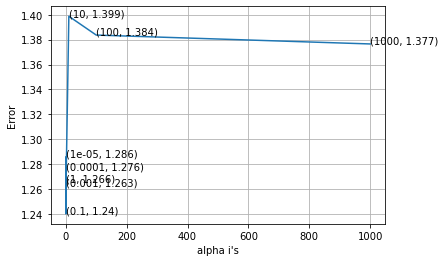

In [74]:
#plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],np.round(txt,decimals=3)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

In [75]:

best_alpha = np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotcoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotcoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.1 The train logloss is: 0.8344977359883337
For value of best alpha =  0.1 The cv logloss is: 1.2399845777284102
For value of best alpha =  0.1 The test logloss is: 1.2614894052202743


log loss: 1.2399845777284106
No.of mis-classified points: 0.38721804511278196
-------------------- Confusion matrix --------------------


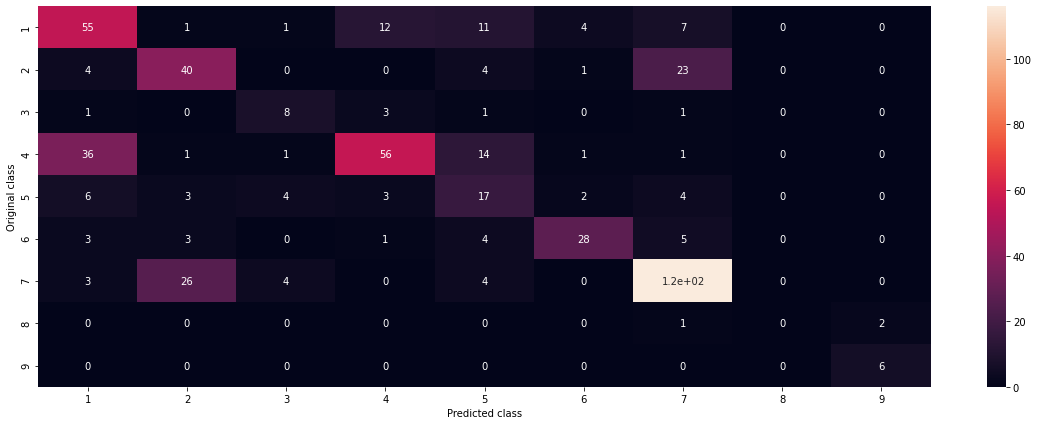

-------------------- Precision matrix --------------------


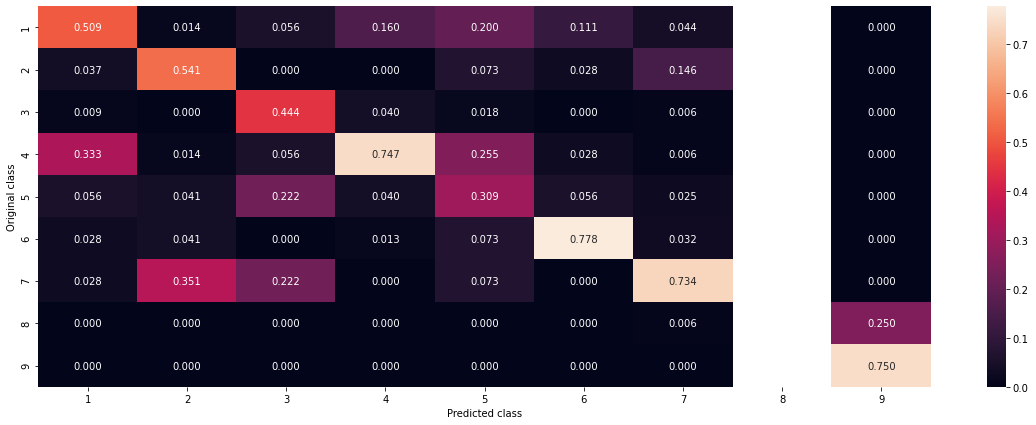

-------------------- Recall matrix --------------------


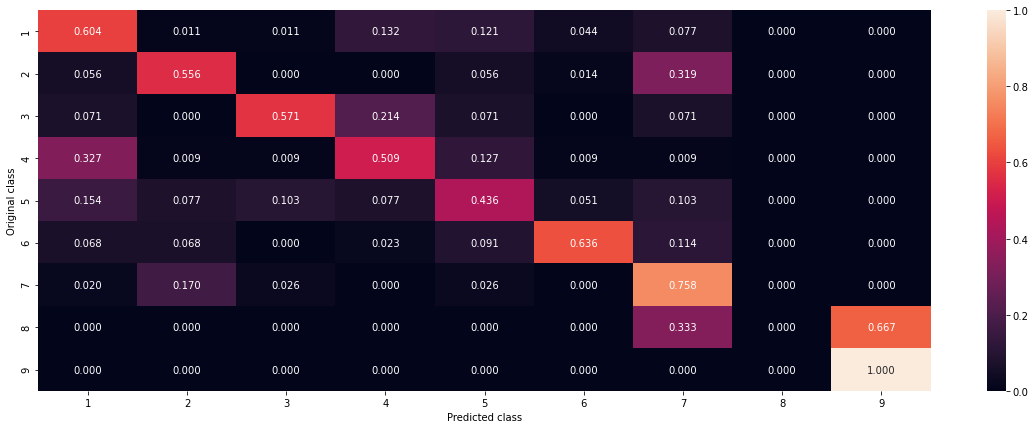

In [95]:
clf_NB = clf = MultinomialNB(alpha=0.1)
predict_and_plot_confusion_matrix(train_x_onehotcoding,train_y,cv_x_onehotcoding.toarray(),cv_y,clf_NB)

In [88]:
test_point_index=5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted class 7
Predicted class probablities: [[0.07755735 0.0703911  0.01159304 0.10380493 0.0317354  0.02907664
  0.66800058 0.00429232 0.00354864]]
Actual class: 7


# 2. K Nearest Neighbour Classification

In [90]:
alpha = [5, 11,15,21, 31, 41, 51, 99]
cv_log_error = []
for i in alpha:
    print("For alpha =",i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responsecoding,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_responsecoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responsecoding)
    cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss:",log_loss(cv_y,sig_clf_probs))

For alpha = 5
Log Loss: 1.1094189788871511
For alpha = 11
Log Loss: 1.08516491299963
For alpha = 15
Log Loss: 1.1099236012988811
For alpha = 21
Log Loss: 1.1356657587105057
For alpha = 31
Log Loss: 1.1435895262321794
For alpha = 41
Log Loss: 1.142012377237034
For alpha = 51
Log Loss: 1.1375929669040417
For alpha = 99
Log Loss: 1.1549070290152


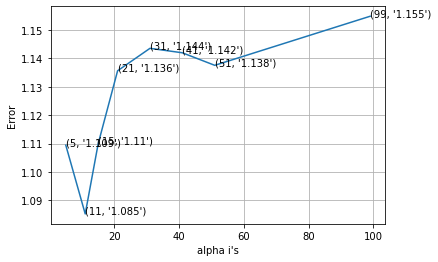

In [91]:
#plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

best k = 11

In [98]:
best_alpha = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responsecoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responsecoding,train_y)

predict_y = sig_clf.predict_proba(train_x_responsecoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responsecoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responsecoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))

For value of best alpha =  11 The train logloss is: 0.6080049028293779
For value of best alpha =  11 The cv logloss is: 1.08516491299963
For value of best alpha =  11 The test logloss is: 1.0363689903621913


log loss: 1.08516491299963
No.of mis-classified points: 0.38721804511278196
-------------------- Confusion matrix --------------------


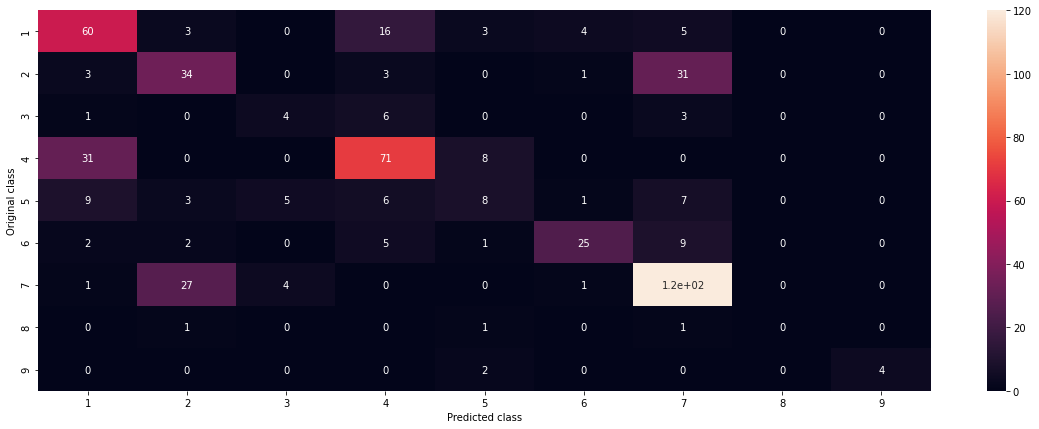

-------------------- Precision matrix --------------------


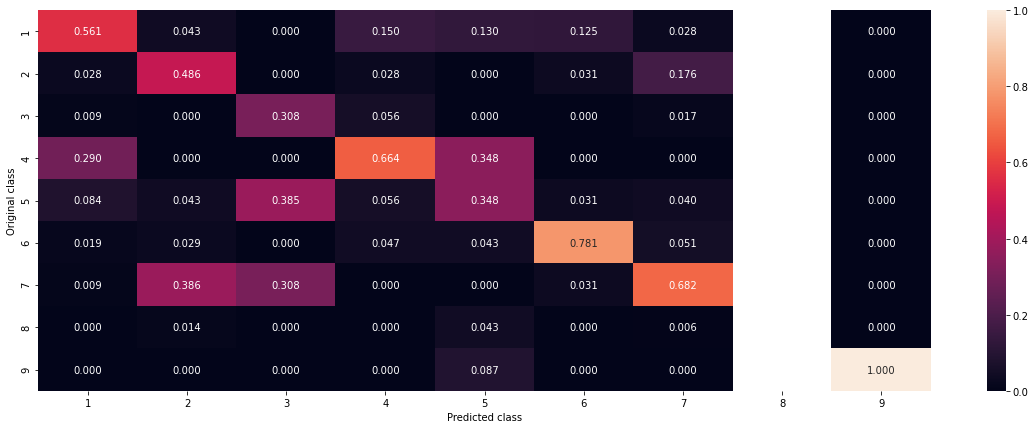

-------------------- Recall matrix --------------------


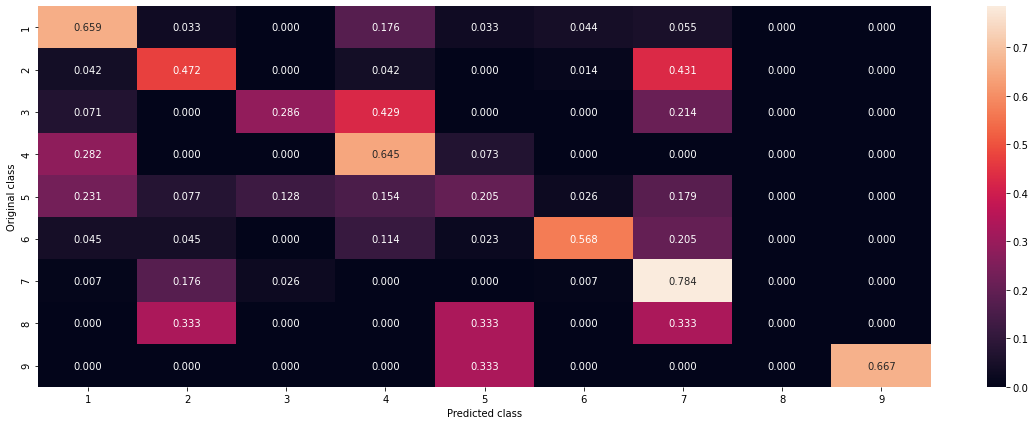

In [96]:
clf_KNN = KNeighborsClassifier(n_neighbors=11)
predict_and_plot_confusion_matrix(train_x_responsecoding,train_y,cv_x_responsecoding,cv_y,clf_KNN)

In [109]:
test_point_index=1

predicted_cls = sig_clf.predict(test_x_responsecoding[test_point_index].reshape(1,-1))
print("Predicted class",predicted_cls[0])
print("Actual class:",test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responsecoding[test_point_index].reshape(1,-1))
print("The",alpha[best_alpha],"nearest neighbours are:",train_y[neighbors[1][0]])
print("Frequency of nearest points:",Counter(train_y[neighbors[1][0]]))

Predicted class 1
Actual class: 5
The 11 nearest neighbours are: [1 1 5 6 6 5 6 1 1 5 6]
Frequency of nearest points: Counter({1: 4, 6: 4, 5: 3})


# 3. Logistic Regression

Balanced weights

Types of losses:  

__Logistic__: Logistic Regression
,__Hinge__ : SVM classifier

In [41]:
alpha = [10 ** x for x in range(-6,3)]
cv_log_error = []
for i in alpha:
    print("For alpha =",i)
    clf = SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotcoding,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotcoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss:",log_loss(cv_y,sig_clf_probs))

For alpha = 1e-06
Log Loss: 1.3215692051571324
For alpha = 1e-05
Log Loss: 1.2949492417336026
For alpha = 0.0001
Log Loss: 1.1309614056044734
For alpha = 0.001
Log Loss: 1.1218188324402523
For alpha = 0.01
Log Loss: 1.1560709112899314
For alpha = 0.1
Log Loss: 1.502465950739942
For alpha = 1
Log Loss: 1.709923523463104
For alpha = 10
Log Loss: 1.7373021190241147
For alpha = 100
Log Loss: 1.7402216685460463


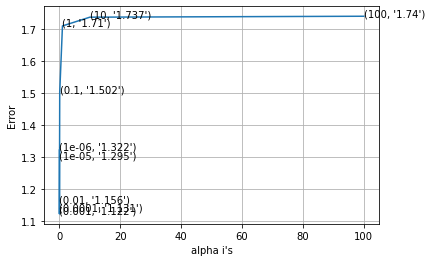

In [42]:
#plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

best alpha = 0.001

In [43]:
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotcoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotcoding,train_y)
    

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.001 The train logloss is: 0.5229247196117227
For value of best alpha =  0.001 The cv logloss is: 1.1218188324402523
For value of best alpha =  0.001 The test logloss is: 1.1293581502968564


log loss: 1.1218188324402523
No.of mis-classified points: 0.36466165413533835
-------------------- Confusion matrix --------------------


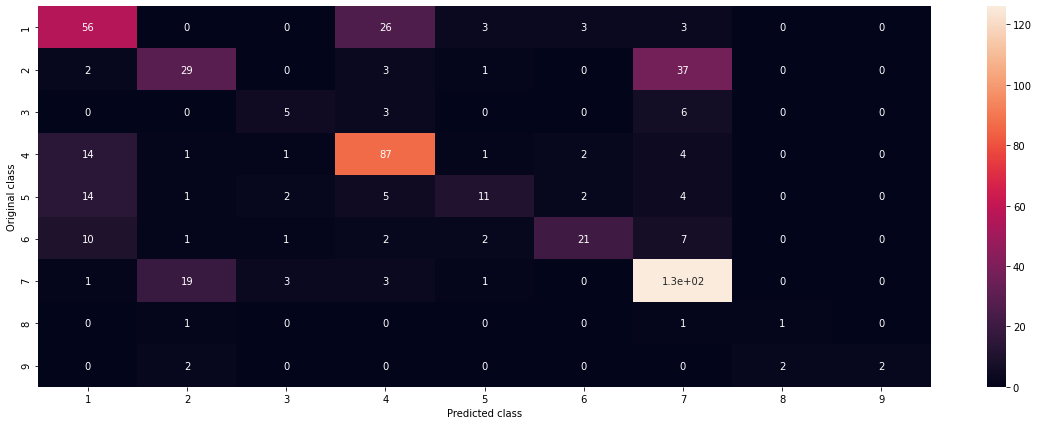

-------------------- Precision matrix --------------------


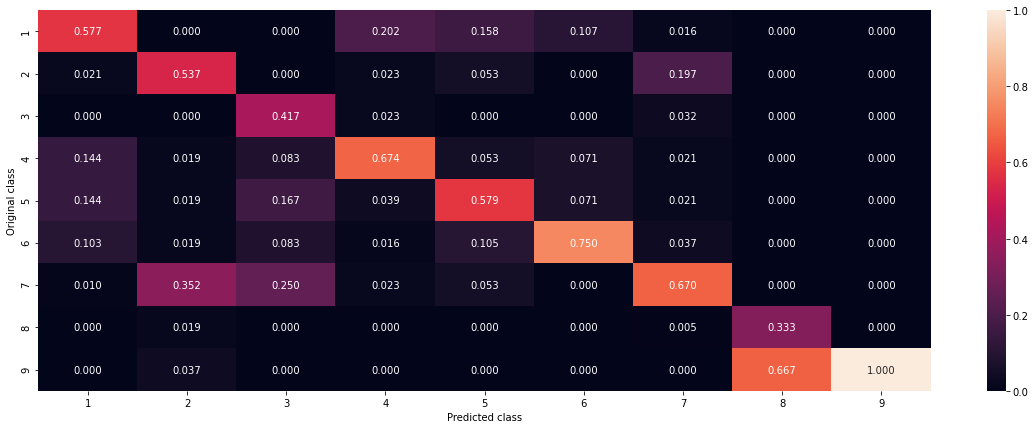

-------------------- Recall matrix --------------------


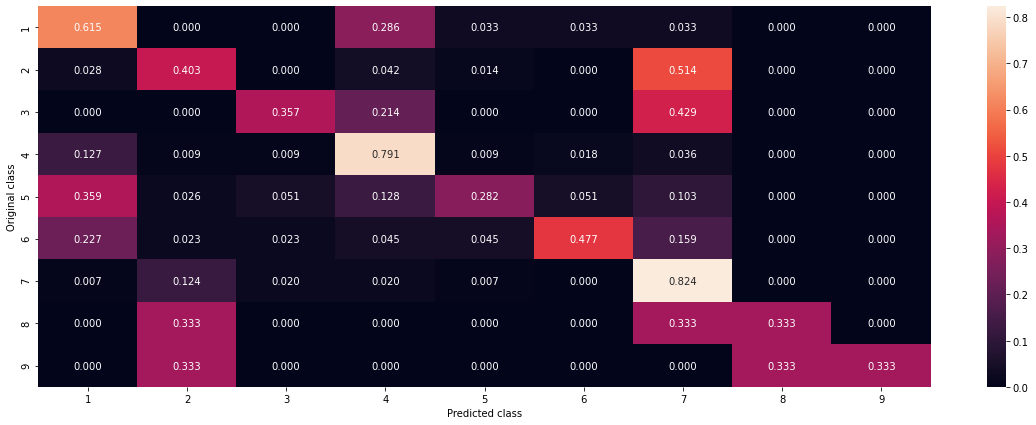

In [45]:
clf_LR = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding,train_y,cv_x_onehotcoding.toarray(),cv_y,clf_LR)

In [117]:
test_point_index=6
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted class 2
Predicted class probablities: [[0.01487607 0.94923155 0.00136227 0.00834856 0.00530495 0.00419079
  0.01062862 0.00443072 0.00162646]]
Actual class: 2


Unbalanced weights

In [121]:
alpha = [10 ** x for x in range(-6,3)]
cv_log_error = []
for i in alpha:
    print("For alpha =",i)
    clf = SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotcoding,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotcoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss:",log_loss(cv_y,sig_clf_probs))

For alpha = 1e-06
Log Loss: 1.357445254598975
For alpha = 1e-05
Log Loss: 1.2843390881980112
For alpha = 0.0001
Log Loss: 1.1630085572917719
For alpha = 0.001
Log Loss: 1.1411517342630237
For alpha = 0.01
Log Loss: 1.232193259049365
For alpha = 0.1
Log Loss: 1.3995748991654362
For alpha = 1
Log Loss: 1.6045334158969184
For alpha = 10
Log Loss: 1.6405182595790193
For alpha = 100
Log Loss: 1.644448985385133


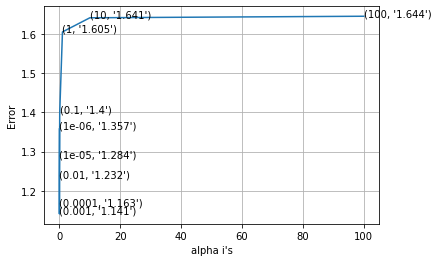

In [122]:
#plotting loss
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

In [123]:
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotcoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotcoding,train_y)
    

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


For value of best alpha =  0.001 The train logloss is: 0.5202023779890171
For value of best alpha =  0.001 The cv logloss is: 1.1411517342630237
For value of best alpha =  0.001 The test logloss is: 1.0538507965158759


log loss: 1.1411517342630237
No.of mis-classified points: 0.35526315789473684
-------------------- Confusion matrix --------------------


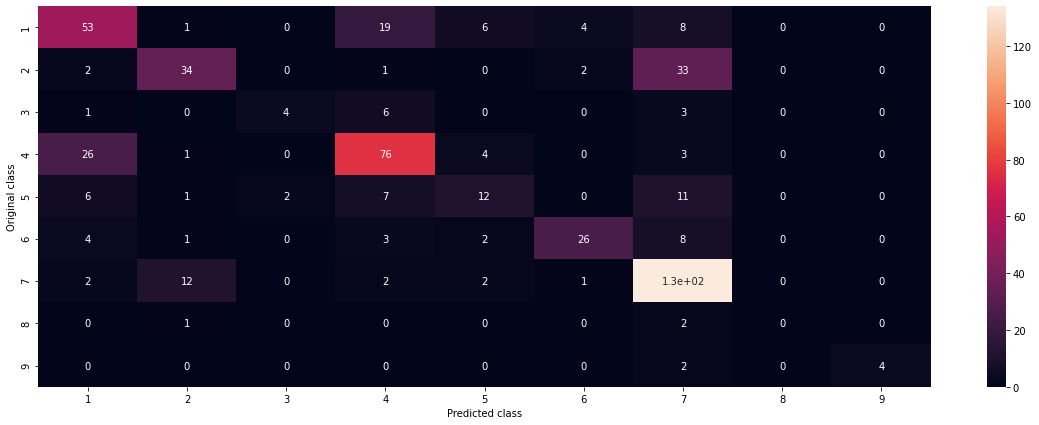

-------------------- Precision matrix --------------------


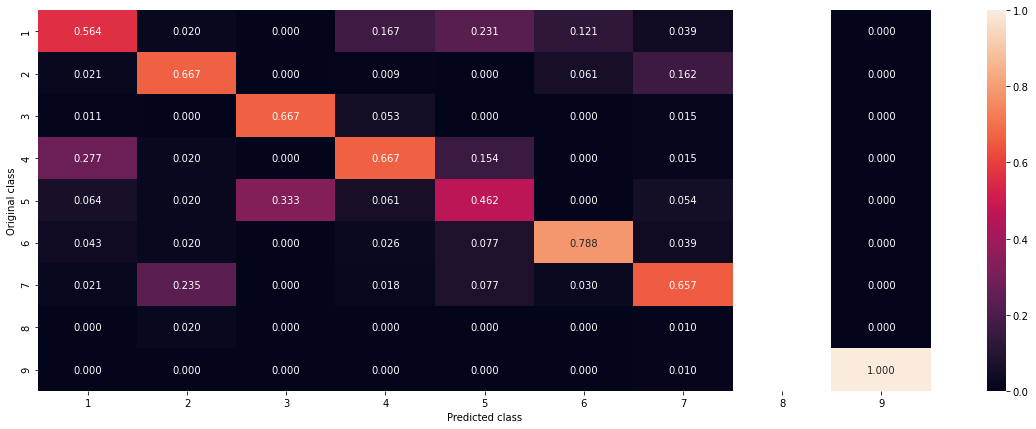

-------------------- Recall matrix --------------------


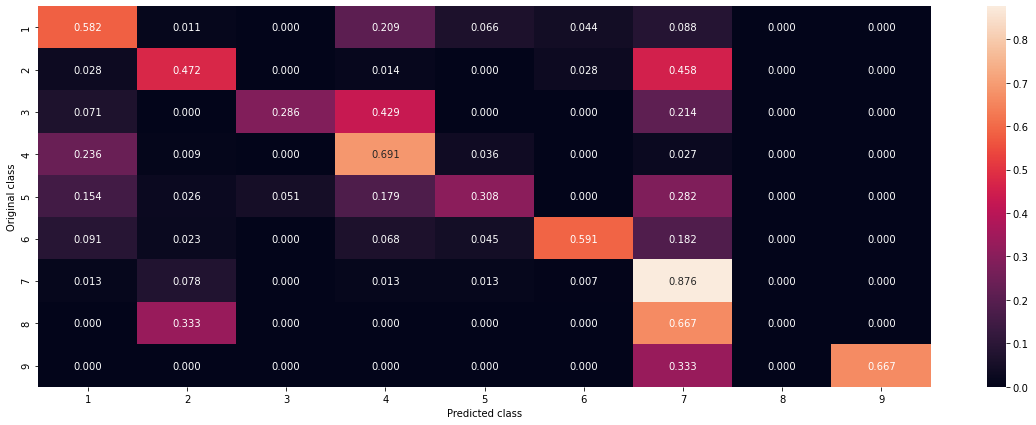

In [125]:
clf_LR_balanced = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding,train_y,cv_x_onehotcoding.toarray(),cv_y,clf_LR_balanced)

In [126]:
test_point_index=6
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted class 2
Predicted class probablities: [[1.53137402e-02 9.51004507e-01 1.06938179e-03 8.52131415e-03
  5.12805911e-03 4.16059117e-03 9.90505192e-03 4.28215423e-03
  6.15200372e-04]]
Actual class: 2


# 4.Linear SVM

For C = 1e-06
Log Loss: 1.3633729164116613
For C = 1e-05
Log Loss: 1.3325339540514054
For C = 0.0001
Log Loss: 1.2431445705629505
For C = 0.001
Log Loss: 1.142288158566767
For C = 0.01
Log Loss: 1.1573102940854159
For C = 0.1
Log Loss: 1.3831378536839
For C = 1
Log Loss: 1.7233638790393309
For C = 10
Log Loss: 1.7321934292574108
For C = 100
Log Loss: 1.732193423609475


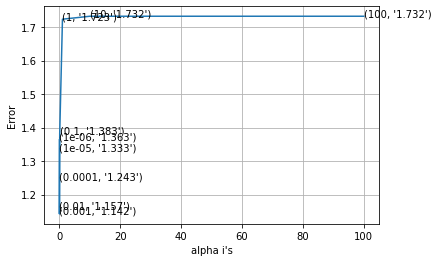

For value of best alpha =  0.001 The train logloss is: 0.5383362089495326
For value of best alpha =  0.001 The cv logloss is: 1.142288158566767
For value of best alpha =  0.001 The test logloss is: 1.1553126809690373


In [128]:
alpha = [10 ** x for x in range(-6,3)]
cv_log_error = []
for i in alpha:
    print("For C =",i)
    clf = SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='hinge',random_state=42)
    clf.fit(train_x_onehotcoding,train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotcoding,train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
    print("Log Loss:",log_loss(cv_y,sig_clf_probs))
    
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42)
clf.fit(train_x_onehotcoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotcoding,train_y)
    

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print("For value of best alpha = ",alpha[best_alpha],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


log loss: 1.1422881585667668
No.of mis-classified points: 0.34774436090225563
-------------------- Confusion matrix --------------------


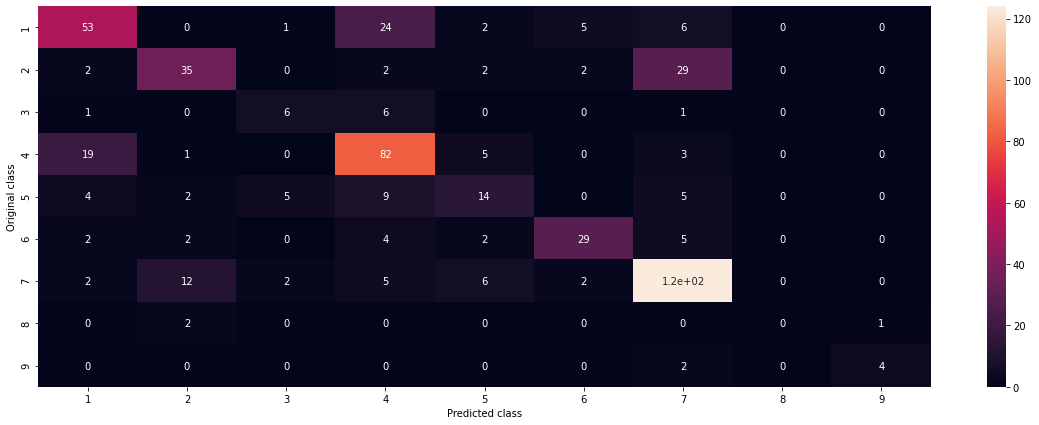

-------------------- Precision matrix --------------------


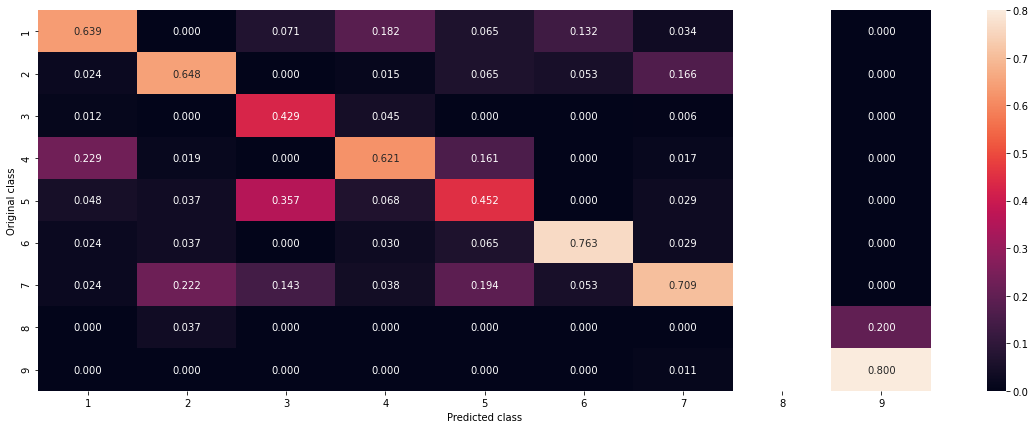

-------------------- Recall matrix --------------------


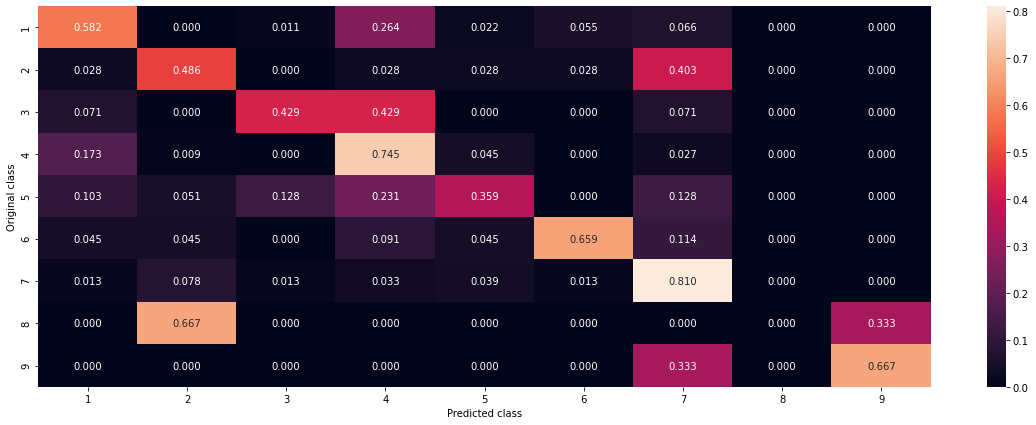

In [129]:
clf_SVM = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding,train_y,cv_x_onehotcoding.toarray(),cv_y,clf_SVM)

In [130]:
test_point_index=6
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted class 2
Predicted class probablities: [[0.03064694 0.86918976 0.00854186 0.02470272 0.02156837 0.01590381
  0.02254297 0.00413184 0.00277174]]
Actual class: 2


# 5.Random Forest

## Model with One hot encoder

In [133]:
alpha = [100,200,500,1000,2000]
max_depth = [5,10]
cv_log_error = []
for i in alpha:
    for j in max_depth:
        print("for n estimators = ",i,"and max depth = ",j)
        clf = RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j)
        clf.fit(train_x_onehotcoding,train_y)
        sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x_onehotcoding,train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
        cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
        print("Log Loss:",log_loss(cv_y,sig_clf_probs))
    
        

for n estimators =  100 and max depth =  5
Log Loss: 1.2831073699657658
for n estimators =  100 and max depth =  10
Log Loss: 1.2012693771950342
for n estimators =  200 and max depth =  5
Log Loss: 1.267998001069286
for n estimators =  200 and max depth =  10
Log Loss: 1.2007172703909677
for n estimators =  500 and max depth =  5
Log Loss: 1.2634870735696406
for n estimators =  500 and max depth =  10
Log Loss: 1.1929440433107594
for n estimators =  1000 and max depth =  5
Log Loss: 1.2624445842479401
for n estimators =  1000 and max depth =  10
Log Loss: 1.1961425819752236
for n estimators =  2000 and max depth =  5
Log Loss: 1.2550519423578022
for n estimators =  2000 and max depth =  10
Log Loss: 1.1940754256132862


In [135]:
best_alpha = np.argmin(cv_log_error)
clf = RandomForestClassifier(n_estimators=alpha[best_alpha//2],criterion='gini',max_depth=10)
clf.fit(train_x_onehotcoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotcoding,train_y)
    

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print("For value of best estimator = ",alpha[best_alpha//2],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print("For value of best estimator = ",alpha[best_alpha//2],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print("For value of best estimator = ",alpha[best_alpha//2],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


For value of best estimator =  500 The train logloss is: 0.7047177712286607
For value of best estimator =  500 The cv logloss is: 1.1988366740584304
For value of best estimator =  500 The test logloss is: 1.1644786336917088


log loss: 1.2031938481899718
No.of mis-classified points: 0.41729323308270677
-------------------- Confusion matrix --------------------


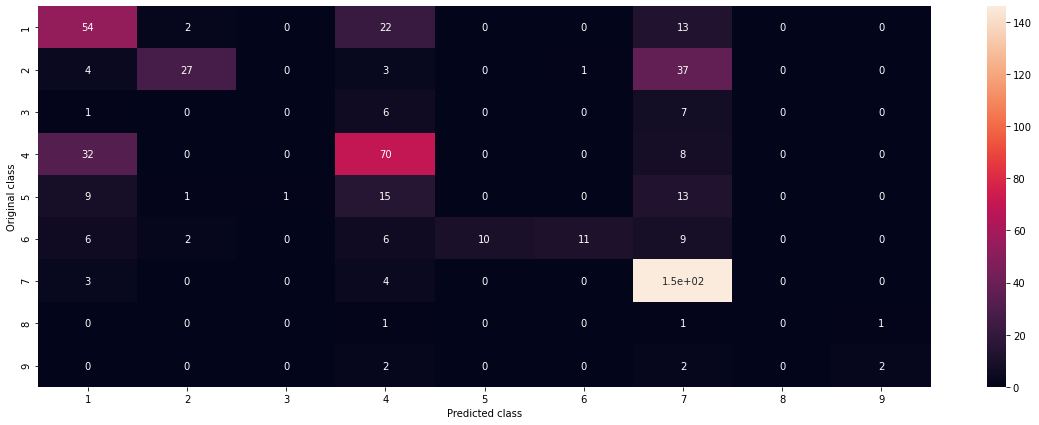

-------------------- Precision matrix --------------------


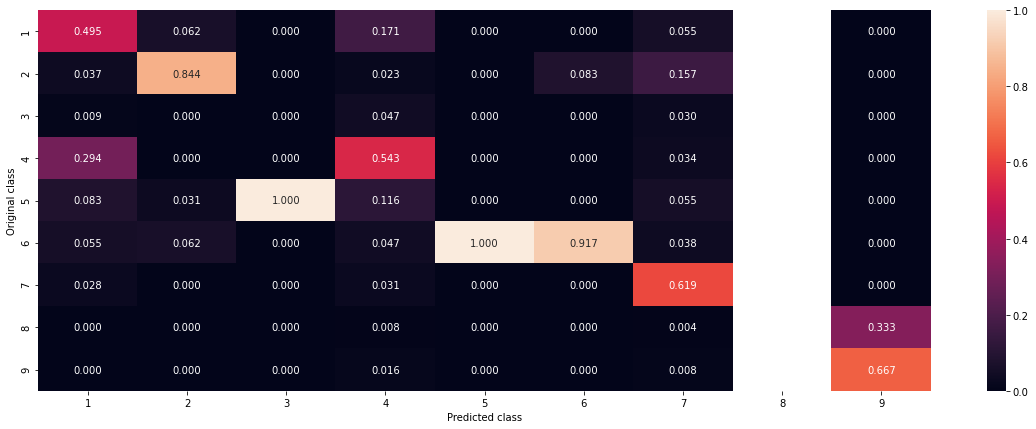

-------------------- Recall matrix --------------------


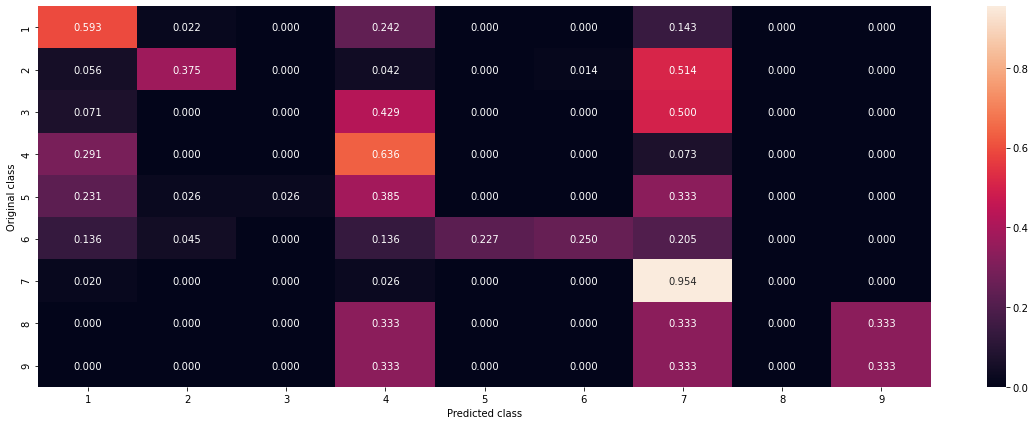

In [136]:
clf_RF_1H = RandomForestClassifier(n_estimators=alpha[best_alpha//2],criterion='gini',max_depth=10)
predict_and_plot_confusion_matrix(train_x_onehotcoding,train_y,cv_x_onehotcoding.toarray(),cv_y,clf_RF_1H)

In [138]:
test_point_index=6
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)

Predicted class 2
Predicted class probablities: [[0.12889416 0.47899719 0.02074329 0.10490439 0.04911146 0.03933923
  0.16268073 0.00654958 0.00877997]]
Actual class: 2


## Model with Response encoding

In [139]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error = []
for i in alpha:
    for j in max_depth:
        print("for n estimators = ",i,"and max depth = ",j)
        clf = RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j)
        clf.fit(train_x_responsecoding,train_y)
        sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x_responsecoding,train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responsecoding)
        cv_log_error.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
        print("Log Loss:",log_loss(cv_y,sig_clf_probs))

for n estimators =  10 and max depth =  2
Log Loss: 1.7663404411302708
for n estimators =  10 and max depth =  3
Log Loss: 1.463266214929581
for n estimators =  10 and max depth =  5
Log Loss: 1.3772289272444231
for n estimators =  10 and max depth =  10
Log Loss: 1.8924150000955495
for n estimators =  50 and max depth =  2
Log Loss: 1.668220791106051
for n estimators =  50 and max depth =  3
Log Loss: 1.509173951359338
for n estimators =  50 and max depth =  5
Log Loss: 1.3995099889956635
for n estimators =  50 and max depth =  10
Log Loss: 1.6776436296467891
for n estimators =  100 and max depth =  2
Log Loss: 1.7638642186753897
for n estimators =  100 and max depth =  3
Log Loss: 1.5612274976060259
for n estimators =  100 and max depth =  5
Log Loss: 1.3158080799994314
for n estimators =  100 and max depth =  10
Log Loss: 1.68156924841724
for n estimators =  200 and max depth =  2
Log Loss: 1.784213177245276
for n estimators =  200 and max depth =  3
Log Loss: 1.481303520580574
for 

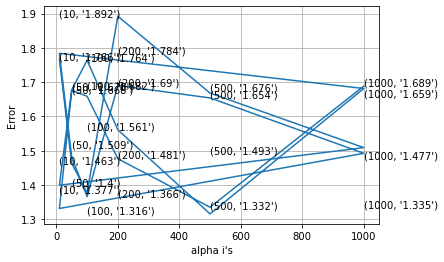

In [141]:
fig,ax = plt.subplots()
ax.plot(alpha*4,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,decimals=3)):
    ax.annotate((alpha[i//4],str(txt)),(alpha[i//4],cv_log_error[i]))
plt.grid()
plt.xlabel("alpha i's")
plt.ylabel("Error")
plt.show()

In [142]:
best_alpha = np.argmin(cv_log_error)
clf = RandomForestClassifier(n_estimators=alpha[best_alpha//4],criterion='gini',max_depth=5)
clf.fit(train_x_responsecoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responsecoding,train_y)
    

predict_y = sig_clf.predict_proba(train_x_responsecoding)
print("For value of best estimator = ",alpha[best_alpha//4],"The train logloss is:",log_loss(train_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responsecoding)
print("For value of best estimator = ",alpha[best_alpha//4],"The cv logloss is:",log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responsecoding)
print("For value of best estimator = ",alpha[best_alpha//4],"The test logloss is:",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))


For value of best estimator =  100 The train logloss is: 0.06076215327022541
For value of best estimator =  100 The cv logloss is: 1.348879239375278
For value of best estimator =  100 The test logloss is: 1.278912797367822


log loss: 1.3441792273835216
No.of mis-classified points: 0.4718045112781955
-------------------- Confusion matrix --------------------


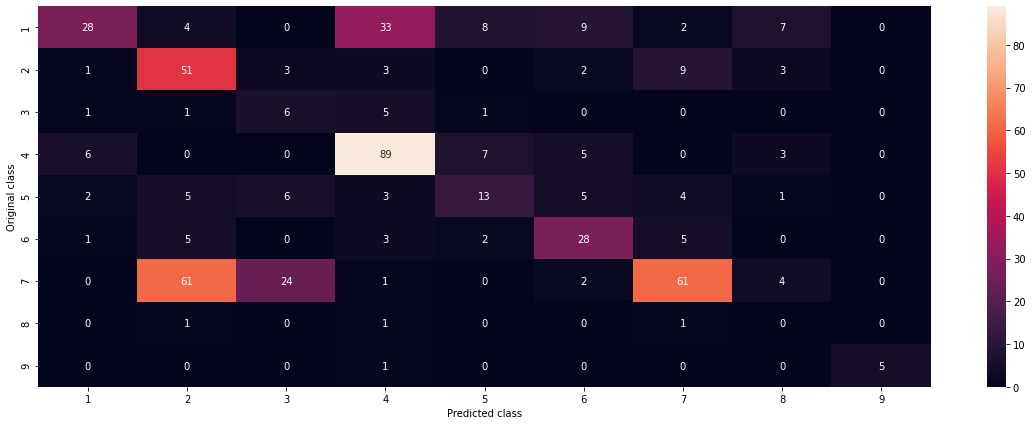

-------------------- Precision matrix --------------------


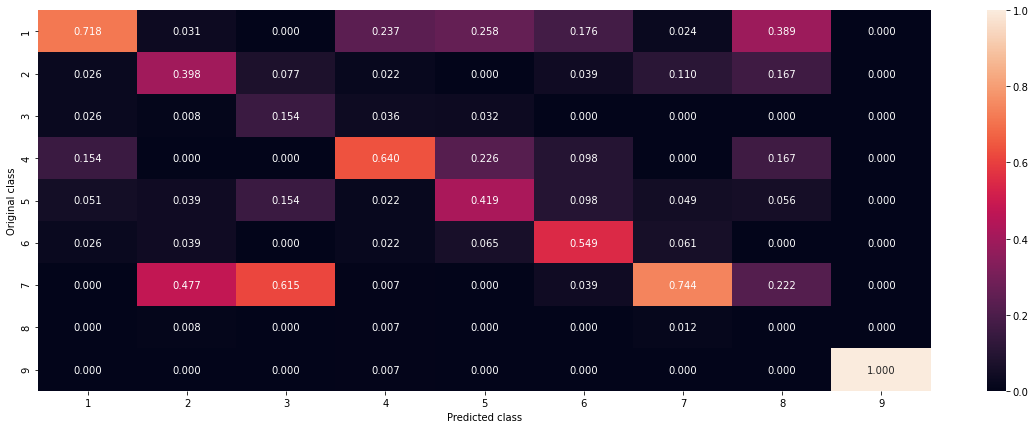

-------------------- Recall matrix --------------------


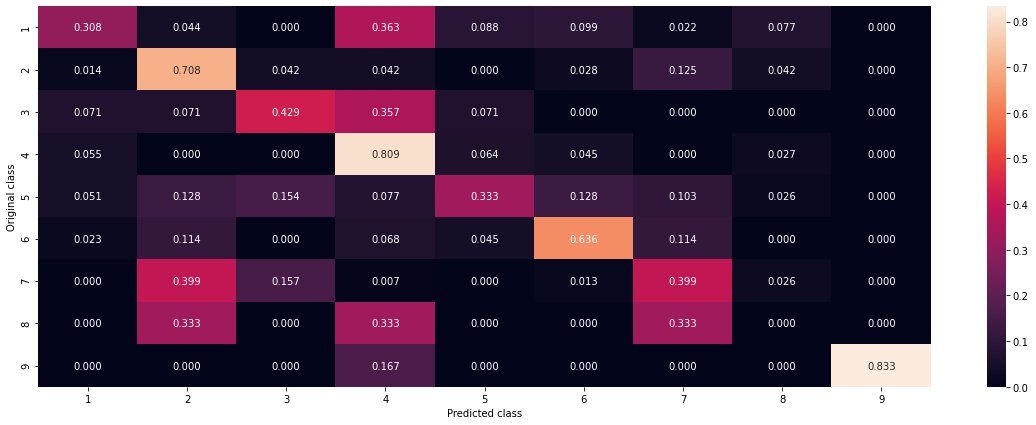

In [143]:
clf_RF_RE = RandomForestClassifier(n_estimators=alpha[best_alpha//4],criterion='gini',max_depth=5)
predict_and_plot_confusion_matrix(train_x_responsecoding,train_y,cv_x_responsecoding,cv_y,clf_RF_RE)

In [147]:
test_point_index=6
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responsecoding[test_point_index].reshape(1,-1))
print("Predicted class",predicted_cls[0])
print("Predicted class probablities:",sig_clf.predict_proba(test_x_responsecoding[test_point_index].reshape(1,-1)))
print("Actual class:",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)

Predicted class 2
Predicted class probablities: [[0.00327572 0.97063355 0.00274067 0.00390559 0.002239   0.0041081
  0.00438796 0.00477541 0.00393399]]
Actual class: 2


# 6.Model with stacking

**Model used**: SDGClassifier(loss='hinge'), SGDClassifier(loss='hinge'),MultinomialNB()


All of them are used in one-hot encoding.

In [152]:
clf_LR = SGDClassifier(class_weight='balanced',alpha=0.001,penalty='l2',loss='log',random_state=42)
clf_LR.fit(train_x_onehotcoding,train_y)
sig_clf_LR = CalibratedClassifierCV(clf_LR,method='sigmoid')

clf_SVM = SGDClassifier(class_weight='balanced',alpha=0.001,penalty='l2',loss='hinge',random_state=42)
clf_SVM.fit(train_x_onehotcoding,train_y)
sig_clf_SVM = CalibratedClassifierCV(clf_SVM,method='sigmoid')

clf_NB = MultinomialNB(alpha=0.1)
clf_NB.fit(train_x_onehotcoding,train_y)
sig_clf_NB = CalibratedClassifierCV(clf_NB,method='sigmoid')

sig_clf_LR.fit(train_x_onehotcoding,train_y)
print("Logistic Regression: logloss is:",log_loss(cv_y,sig_clf_LR.predict_proba(cv_x_onehotcoding),labels=clf_LR.classes_,eps=1e-15))
sig_clf_SVM.fit(train_x_onehotcoding,train_y)
print("Support Vector Machines : logloss is:",log_loss(cv_y,sig_clf_SVM.predict_proba(cv_x_onehotcoding),labels=clf_SVM.classes_,eps=1e-15))
sig_clf_NB.fit(train_x_onehotcoding,train_y)
print("NaiveBaise: logloss is:",log_loss(cv_y,sig_clf_NB.predict_proba(cv_x_onehotcoding),labels=clf_NB.classes_,eps=1e-15))
print("-"*50)

Logistic Regression: logloss is: 1.118161711423741
Support Vector Machines : logloss is: 1.142288158566767
NaiveBaise: logloss is: 1.2399845777284102
--------------------------------------------------


In [153]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf_LR,sig_clf_SVM,sig_clf_NB],meta_classifier=lr)
    sclf.fit(train_x_onehotcoding,train_y)
    print("Stacking Classifier: for alpha ",i," ,logloss is:",log_loss(cv_y,sclf.predict_proba(cv_x_onehotcoding),eps=1e-15,labels=clf_LR.classes_))
    log_error = log_loss(cv_y,sclf.predict_proba(cv_x_onehotcoding))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifier: for alpha  0.0001  ,logloss is: 1.6786516206463844
Stacking Classifier: for alpha  0.001  ,logloss is: 1.6377266214969513
Stacking Classifier: for alpha  0.01  ,logloss is: 1.975638232568644
Stacking Classifier: for alpha  0.1  ,logloss is: 2.862635262740109
Stacking Classifier: for alpha  1  ,logloss is: 3.7695590876000655
Stacking Classifier: for alpha  10  ,logloss is: 4.109431495442295


In [156]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf_LR,sig_clf_SVM,sig_clf_NB],meta_classifier=lr)
sclf.fit(train_x_onehotcoding,train_y)

log_error1 = log_loss(train_y,sclf.predict_proba(train_x_onehotcoding))    
print("logloss (train) is:",log_error1)

log_error2 = log_loss(cv_y,sclf.predict_proba(cv_x_onehotcoding))    
print("logloss (cv) is:",log_error2)

log_error3 = log_loss(test_y,sclf.predict_proba(test_x_onehotcoding))    
print("logloss (test) is:",log_error3)

logloss (train) is: 0.8265531862070855
logloss (cv) is: 3.649406593168455
logloss (test) is: 3.6639856520521925


# Maximum voting classifier

In [158]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr',sig_clf_LR),('svc',sig_clf_SVM),('nb',sig_clf_NB)],voting='soft')
vclf.fit(train_x_onehotcoding,train_y)
print("Log loss (train) is:",log_loss(train_y,vclf.predict_proba(train_x_onehotcoding)))
print("Log loss (cv) is:",log_loss(cv_y,vclf.predict_proba(cv_x_onehotcoding)))
print("Log loss (test) is:",log_loss(test_y,vclf.predict_proba(test_x_onehotcoding)))

Log loss (train) is: 0.6002850905449784
Log loss (cv) is: 1.0779584251523016
Log loss (test) is: 1.0787845486040506


Further we can use TfiD/word2vec/glove rather than B.O.W

# We can conclude Logistic Regression (balanced,1hotencoding) is the best

In [1]:
!unzip '../input/msk-redefining-cancer-treatment/test_text.zip'
!unzip '../input/msk-redefining-cancer-treatment/test_variants.zip'

Archive:  ../input/msk-redefining-cancer-treatment/test_text.zip
  inflating: test_text               
Archive:  ../input/msk-redefining-cancer-treatment/test_variants.zip
  inflating: test_variants           


In [57]:
# Loading training variants. Comma seperated file
data_variants = pd.read_csv('./test_variants')
# Loading training_tex dataset. This is seperated by ||
data_text = pd.read_csv('./test_text',sep="\|\|",engine='python',names=["ID","TEXT"],skiprows=1)

In [58]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def data_text_preprocess(total_text, ind, col):
    # remove int values from the text data
    if type(total_text) is not int:
        string = ""
        # replacing all special char, multiple spaces with single space
        # making all letters lowercase
        total_text = re.sub('[^a-zA-Z0-9\n]',' ',str(total_text))
        total_text = re.sub('\s+',' ',str(total_text))
        total_text = total_text.lower()
        
        for word in total_text.split(' '):
            # remove stop words from text data
            if not word in stop_words:
                string += word + ' '
        
        data_text[col][ind] = string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'],index,'TEXT')

In [60]:
df1 = pd.merge(data_variants,data_text,on='ID',how='left')
df1.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2 mutation resulted myeloproliferative phenoty...
1,1,NAGLU,P521L,abstract large tumor suppressor 1 lats1 serin...
2,2,PAH,L333F,vascular endothelial growth factor receptor ve...
3,3,ING1,A148D,inflammatory myofibroblastic tumor imt neoplas...
4,4,TMEM216,G77A,abstract retinoblastoma pediatric retinal tum...


In [61]:
df1.loc[df1['TEXT'].isnull(),'TEXT'] = df1['Gene'] + ' ' + df1['Variation']

In [71]:
df1.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2 mutation resulted myeloproliferative phenoty...
1,1,NAGLU,P521L,abstract large tumor suppressor 1 lats1 serin...
2,2,PAH,L333F,vascular endothelial growth factor receptor ve...
3,3,ING1,A148D,inflammatory myofibroblastic tumor imt neoplas...
4,4,TMEM216,G77A,abstract retinoblastoma pediatric retinal tum...


In [81]:
Test_gene_feature_onehotcoding = gene_vectorizer.transform(df1['Gene'])

In [83]:
Test_gene_feature_onehotcoding.shape

(5668, 231)

In [84]:
Test_var_feature_onehotcoding = var_vectorizer.transform(df1['Variation'])

In [85]:
Test_var_feature_onehotcoding.shape

(5668, 1949)

In [86]:
Test_text_feature_onehotcoding = text_vectorizer.transform(df1['TEXT'])

In [87]:
Test_text_feature_onehotcoding.shape

(5668, 54356)

In [88]:
Test_text_feature_onehotcoding = normalize(Test_text_feature_onehotcoding,axis=0)

In [89]:
Test_text_feature_onehotcoding.shape

(5668, 54356)

In [90]:
Test_gene_var_onehotcoding = hstack((Test_gene_feature_onehotcoding,Test_var_feature_onehotcoding))
Test_x_onehotcoding = hstack((Test_gene_var_onehotcoding,Test_text_feature_onehotcoding)).tocsr()

In [91]:
Test_x_onehotcoding.shape

(5668, 56536)

In [93]:
predict_y = sig_clf.predict_proba(Test_x_onehotcoding)
submission = pd.DataFrame(predict_y, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = df1['ID']
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.073052,0.092140,0.016048,0.079518,0.043818,0.037181,0.645002,0.005908,0.007333,0
1,0.175880,0.156603,0.030660,0.230080,0.070020,0.086178,0.231346,0.007249,0.011984,1
2,0.115354,0.234718,0.015908,0.113755,0.073624,0.058393,0.373060,0.007147,0.008043,2
3,0.131354,0.224305,0.022054,0.193046,0.060943,0.057272,0.294620,0.007039,0.009367,3
4,0.120722,0.092789,0.011866,0.516889,0.036592,0.033483,0.176281,0.005432,0.005946,4


In [102]:
predict_f = sig_clf.predict(Test_x_onehotcoding)
submission_ = pd.DataFrame(predict_f, columns=['class'])
submission_['ID'] = df1['ID']
submission_.head()

,class,ID
0,7,0
1,7,1
2,7,2
3,7,3
4,4,4


In [103]:
submission_df = pd.get_dummies(submission_, columns=["class"], prefix=["class"],prefix_sep='')

In [104]:
submission_df.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0
2,2,0,0,0,0,0,0,1,0,0
3,3,0,0,0,0,0,0,1,0,0
4,4,0,0,0,1,0,0,0,0,0


In [105]:
submission_df.to_csv('submission.csv', index=False)

In [107]:
kaggle competitions submit -c msk-redefining-cancer-treatment -f submission_df.csv -m "Message"

SyntaxError: invalid syntax (<ipython-input-107-5d129fda26f3>, line 1)